<a href="https://colab.research.google.com/github/encodeArnab/Text-Translation-Glasses/blob/main/NLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install h5py pyyaml

In [58]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [59]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open("deu.txt", mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text


In [60]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [61]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:25000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom was motivated.', 'Tom war motiviert.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3415127 (CK) & #6625221 (Felixjp)'],
       ['Tom was my friend.', 'Tom war mein Freund.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3165799 (Hybrid) & #3168521 (Pfirsichbaeumchen)'],
       ['Tom was mystified.', 'Tom war verblüfft.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6039878 (Hybrid) & #3361288 (freddy1)']],
      dtype='<U120')

In [62]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom was motivated', 'Tom war motiviert',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3415127 (CK) & #6625221 (Felixjp)'],
       ['Tom was my friend', 'Tom war mein Freund',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3165799 (Hybrid) & #3168521 (Pfirsichbaeumchen)'],
       ['Tom was mystified', 'Tom war verblüfft',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6039878 (Hybrid) & #3361288 (freddy1)']],
      dtype='<U120')

In [63]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['tom was motivated', 'tom war motiviert',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3415127 (CK) & #6625221 (Felixjp)'],
       ['tom was my friend', 'tom war mein freund',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3165799 (Hybrid) & #3168521 (Pfirsichbaeumchen)'],
       ['tom was mystified', 'tom war verblüfft',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6039878 (Hybrid) & #3361288 (freddy1)']],
      dtype='<U120')

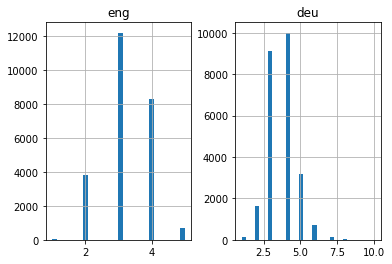

In [64]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [65]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [66]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4268


In [67]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 6696


In [68]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [69]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [70]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [71]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [72]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [77]:

checkpoint_path = "training_1/cp.cpkt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,verbose=1)

filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[cp_callback], 
                    verbose=1)

Epoch 1/30
32/32 [==============================] - 109s 3s/step - loss: 2.3412 - val_loss: 2.3863

Epoch 00001: saving model to training_1/cp.cpkt
Epoch 2/30
32/32 [==============================] - 109s 3s/step - loss: 2.2439 - val_loss: 2.2404

Epoch 00002: saving model to training_1/cp.cpkt
Epoch 3/30
32/32 [==============================] - 114s 4s/step - loss: 2.1198 - val_loss: 2.1628

Epoch 00003: saving model to training_1/cp.cpkt
Epoch 4/30
32/32 [==============================] - 110s 3s/step - loss: 2.0104 - val_loss: 2.1031

Epoch 00004: saving model to training_1/cp.cpkt
Epoch 5/30
32/32 [==============================] - 110s 3s/step - loss: 1.9246 - val_loss: 2.0653

Epoch 00005: saving model to training_1/cp.cpkt
Epoch 6/30
32/32 [==============================] - 110s 3s/step - loss: 1.8519 - val_loss: 1.9883

Epoch 00006: saving model to training_1/cp.cpkt
Epoch 7/30
32/32 [==============================] - 110s 3s/step - loss: 1.7809 - val_loss: 1.9422

Epoch 00007:

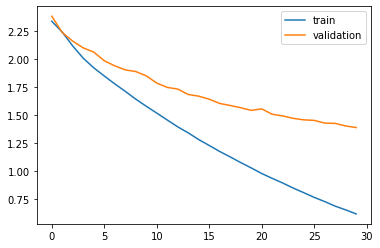

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [80]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [81]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [83]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
2151,she betrayed you,they trusted you
2332,ive checked,i have plans
3006,tom is humiliated,tom was cremated
3373,are you working,do you them
1636,tom bent forward,tom graduated dinner
504,tom is tidy,toms is
3125,have you gone mad,are you crazy
1701,is he tom,is he arrived
1610,i like it hot,i like here
4401,the food is ready,the foods


In [88]:
model.evaluate(testX, testY, batch_size=512)

10/10 [==============================] - 11s 1s/step - loss: 1.3926


1.3926031589508057

In [84]:
model.evaluate(trainX, trainY, batch_size=512)

40/40 [==============================] - 47s 1s/step - loss: 0.7273


0.7272845506668091

In [87]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)


./1611494880.h5
